<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Advanced Indexing

## Learning Objectives

* Vectorized Indexing 
* Dropping/Masking Data Using `where` and `isin`
* Fancy DateTime Indexing


## Overview


In the pervious notebooks, we learned basic forms of indexing with xarray (positional and name based dimensions, integer and label based indexing) and nearest neighbor lookups. In this tutorial, we will discover more advanced options for vectorized indexing and learn about additional useful methods relating to indexing/selecting data such as masking. 


First, let's import packages: 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In this tutorial, we’ll use air temperature tutorial dataset from the National Center for Environmental Prediction.  

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
da = ds.air
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Vectorized Indexing

Like NumPy and pandas, Xarray supports indexing many array elements at once in a
*vectorized* manner. 

If you only provide integers, slices, or unlabeled arrays (array without dimension names, such as `np.ndarray`, `list`, but not `DataArray()`) indexing can be understood as orthogonally.

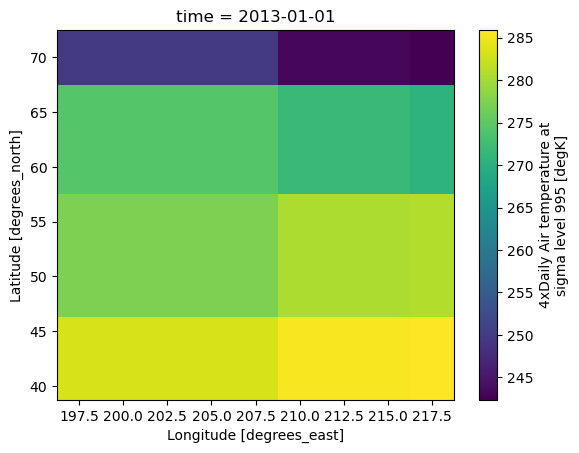

In [3]:
da[0,[2,4,10,13],[1,6,7]].plot();

But for more flexibility, you can supply `DataArray()` objects as indexers. 

Vectorized indexing using `DataArrays()` may be used to extract information from the nearest grid cells of interest, for example, the nearest climate model grid cells to a collection specified weather station latitudes and longitudes.

**To trigger vectorized indexing behavior you will need to provide the selection dimensions with a new shared output dimension name.** 

In the example below, the selections of the closest latitude and longitude are renamed to an output dimension named `points`:

In [4]:
# Define target latitude and longitude (where weather stations might be)
lat_points = xr.DataArray([31, 41, 42, 42], dims="points")
lon_points = xr.DataArray([200, 201, 202, 205], dims="points")
lat_points

<xarray.DataArray (points: 4)>
array([31, 41, 42, 42])
Dimensions without coordinates: points

In [5]:
lon_points

<xarray.DataArray (points: 4)>
array([200, 201, 202, 205])
Dimensions without coordinates: points

Now, retrieve data at the grid cells nearest to the target latitudes and longitudes (weather stations):

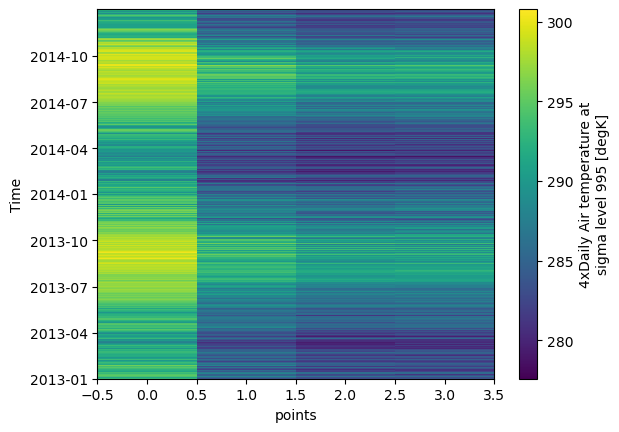

In [6]:
da.sel(lat=lat_points, lon=lon_points,method="nearest").plot();

As we can see in the above example, the dimensions on resultant arrays are given by the ordered union of the indexers’ dimensions.

In [7]:
da.sel(lat=lat_points, lon=lon_points,method="nearest").dims

('time', 'points')

Please note that slices or sequences/arrays without named-dimensions are treated as if they have the same dimension which is indexed along:

In [8]:
da.sel(lat=[20, 30, 40], lon=lon_points,method="nearest")

<xarray.DataArray 'air' (time: 2920, lat: 3, points: 4)>
array([[[296.6    , 296.6    , 296.19998, 296.4    ],
        [293.1    , 293.1    , 293.29   , 293.29   ],
        [284.6    , 284.6    , 284.9    , 284.19998]],

       [[296.4    , 296.4    , 295.9    , 296.19998],
        [293.19998, 293.19998, 293.9    , 294.19998],
        [283.29   , 283.29   , 285.19998, 285.19998]],

       [[295.6    , 295.6    , 295.4    , 295.4    ],
        [292.4    , 292.4    , 292.9    , 293.4    ],
        [282.     , 282.     , 283.29   , 284.69998]],

       ...,

       [[294.79   , 294.79   , 295.29   , 297.49   ],
        [288.88998, 288.88998, 289.19   , 290.88998],
        [282.49   , 282.49   , 281.99   , 281.99   ]],

       [[293.69   , 293.69   , 293.88998, 295.38998],
        [288.29   , 288.29   , 289.19   , 290.79   ],
        [282.09   , 282.09   , 281.59   , 282.38998]],

       [[293.79   , 293.79   , 293.69   , 295.09   ],
        [289.49   , 289.49   , 290.38998, 291.59   ],
        [282.09   , 282.09   , 281.99   , 283.09   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 20.0 30.0 40.0
    lon      (points) float32 200.0 200.0 202.5 205.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Dimensions without coordinates: points
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

<div class="alert alert-block alert-warning">
    
<strong>Warning:</strong> If an indexer is a DataArray(), its coordinates should not conflict with the selected subpart of the target array (except for the explicitly indexed dimensions with .loc/.sel). Otherwise, IndexError will be raised.
    
</div>


## Masking with `where()`

Indexing methods on Xarray objects generally return a subset of the original data. However, it is sometimes useful to select an object with the same shape as the original data, but with some elements masked. To do this type of selection in Xarray, use `where()`:

In [9]:
# Let's replace the missing values (nan) with some placeholder

ds.air.where(ds.air.notnull(), -9999)

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
         294.29   ],
        [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
         294.38998],
        [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
         295.19   ]],

       [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
         241.79   ],
        [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
         241.68999],
        [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
         246.29   ],
        ...,
        [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
         294.69   ],
        [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
         295.19   ],
        [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
         295.69   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

We can also select a condition to create a mask. For example, here we want to mask all the points with latitudes above 60 N. 

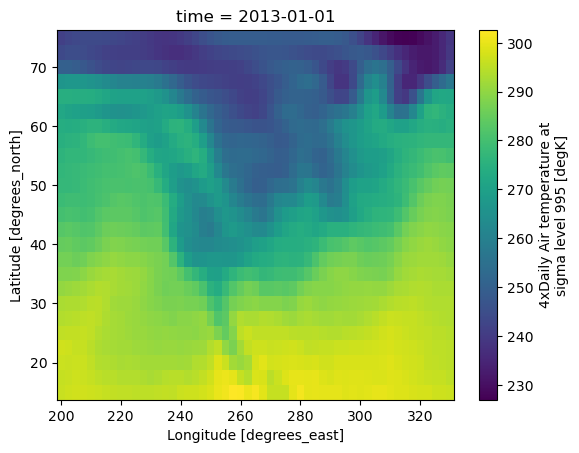

In [10]:
da[0,:,:].plot();

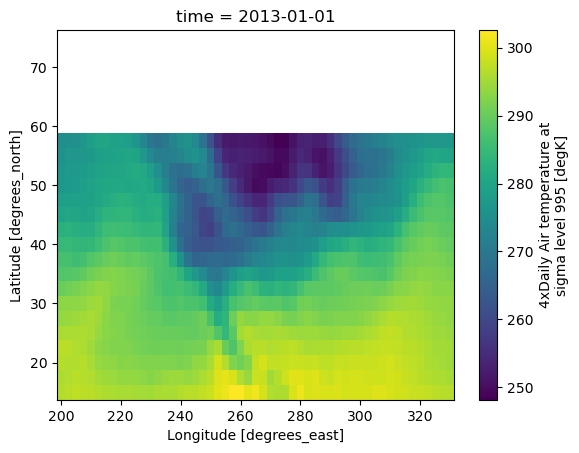

In [11]:
da_masked = da.where(da.lat<60)
da_masked[0,:,:].plot();

By default where maintains the original size of the data. You can use of the option `drop=True` to clips coordinate elements that are fully masked:


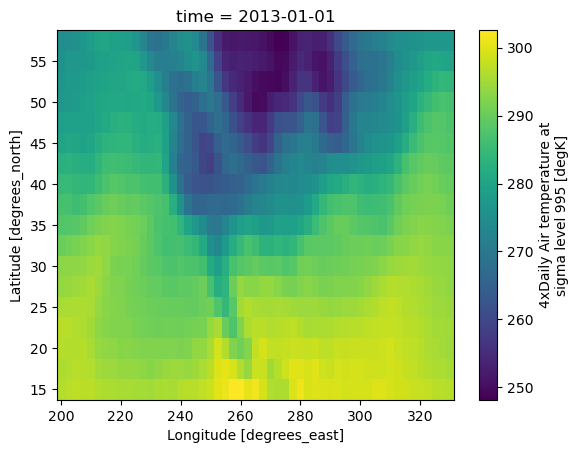

In [12]:
da_masked = da.where(da.lat<60, drop=True)
da_masked[0,:,:].plot();

## Selecting Values with `isin`

To check whether elements of an xarray object contain a single object, you can compare with the equality operator `==` (e.g., `arr == 3`). To check multiple values, use `isin()`:



Here is a simple example: 

In [13]:
x_da = xr.DataArray([1, 2, 3, 4, 5], dims=["x"])

#-- select points with values equal to 2 and 4:
x_da.isin([2, 4])

<xarray.DataArray (x: 5)>
array([False,  True, False,  True, False])
Dimensions without coordinates: x

`isin()` works particularly well with `where()` to support indexing by arrays that are not already labels of an array. 

For example, we have another DataArray that displays the status flags of the data-collecting device for our data. Here, flags with value 0 and -1 signifies the device was functioning correctly, while 0 indicates a malfunction, implying that the resulting data collected may not be accurate.

In [14]:
flags = xr.DataArray(
    np.random.randint(-1, 5, da.shape),
    dims=da.dims,
    coords=da.coords
)
flags

<xarray.DataArray (time: 2920, lat: 25, lon: 53)>
array([[[ 2,  3,  0, ...,  3,  0,  4],
        [ 3,  1,  0, ...,  4,  2, -1],
        [ 3,  1,  2, ...,  3,  2, -1],
        ...,
        [-1, -1,  3, ...,  0,  3,  3],
        [ 3,  1, -1, ..., -1,  4,  3],
        [ 2, -1,  4, ..., -1,  0,  2]],

       [[ 0,  4,  2, ...,  3,  4,  3],
        [ 3,  0, -1, ...,  2, -1,  4],
        [ 2,  3,  4, ..., -1,  4, -1],
        ...,
        [ 0,  4,  1, ..., -1,  3,  1],
        [ 4,  1,  3, ...,  1, -1, -1],
        [ 3,  1,  1, ...,  3,  4,  2]],

       [[ 1,  2, -1, ...,  1,  0,  2],
        [ 4,  3,  2, ...,  3,  4,  3],
        [ 4,  2, -1, ...,  4,  1,  1],
        ...,
...
        ...,
        [ 1,  0,  4, ...,  2, -1,  4],
        [ 3,  4,  3, ...,  1,  0,  1],
        [ 0,  4,  4, ...,  1,  4,  2]],

       [[ 0,  2,  0, ...,  3,  1,  4],
        [ 3,  2, -1, ...,  0,  4,  2],
        [ 1, -1, -1, ...,  1, -1,  3],
        ...,
        [ 0, -1,  0, ...,  1, -1,  3],
        [ 0,  2,  1, ...,  4,  0,  4],
        [ 2,  2,  0, ...,  0, -1,  2]],

       [[ 4, -1,  0, ...,  4,  0,  1],
        [ 3, -1,  0, ...,  0,  1, -1],
        [ 4, -1,  2, ..., -1,  3,  3],
        ...,
        [ 2,  0,  0, ...,  4,  3,  0],
        [ 2,  4,  2, ...,  3,  3, -1],
        [ 0,  4,  4, ...,  1,  0,  3]]])
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

Now, we want to only see the data for points where out measurement device is working correctly: 

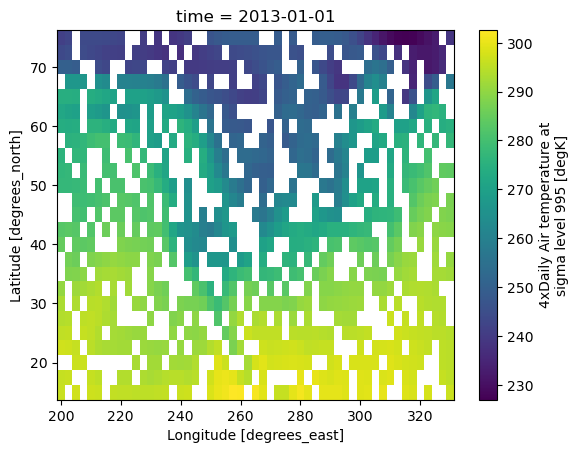

In [15]:
da_masked = da.where(flags.isin([1,2,3,4,5]), drop=True)
da_masked[0,:,:].plot();

<div class="alert alert-block alert-warning">
    
<strong>Warning:</strong> Please note that when done repeatedly, this type of indexing is significantly slower than using sel().
    
</div>

## Align and Reindex 

Xarray enforces alignment between index Coordinates (that is, coordinates with the same name as a dimension, marked by *) on objects used in binary operations.


In [16]:
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[242.09999, 242.7    , 243.09999, ..., 232.     , 233.59999,
         235.79999],
        [243.59999, 244.09999, 244.2    , ..., 231.     , 232.5    ,
         235.7    ],
        [253.2    , 252.89   , 252.09999, ..., 230.79999, 233.39   ,
         238.5    ],
...
        [293.69   , 293.88998, 295.38998, ..., 295.09   , 294.69   ,
         294.29   ],
        [296.29   , 297.19   , 297.59   , ..., 295.29   , 295.09   ,
         294.38998],
        [297.79   , 298.38998, 298.49   , ..., 295.69   , 295.49   ,
         295.19   ]],

       [[245.09   , 244.29   , 243.29   , ..., 241.68999, 241.48999,
         241.79   ],
        [249.89   , 249.29   , 248.39   , ..., 239.59   , 240.29   ,
         241.68999],
        [262.99   , 262.19   , 261.38998, ..., 239.89   , 242.59   ,
         246.29   ],
        ...,
        [293.79   , 293.69   , 295.09   , ..., 295.29   , 295.09   ,
         294.69   ],
        [296.09   , 296.88998, 297.19   , ..., 295.69   , 295.69   ,
         295.19   ],
        [297.69   , 298.09   , 298.09   , ..., 296.49   , 296.19   ,
         295.69   ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [17]:
da = xr.DataArray(
    np.random.rand(4, 3),
    [
        ("time", pd.date_range("2000-01-01", periods=4)),
        ("space", ["IL", "IA", "IN"]),
    ],
)
da

<xarray.DataArray (time: 4, space: 3)>
array([[0.21780543, 0.57711447, 0.86539737],
       [0.14893992, 0.35643873, 0.18224072],
       [0.10407898, 0.95598302, 0.93117286],
       [0.52169098, 0.04393997, 0.97119655]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IL' 'IA' 'IN'

In [18]:
da.reindex(space=["IA", "CA"])

<xarray.DataArray (time: 4, space: 2)>
array([[0.57711447,        nan],
       [0.35643873,        nan],
       [0.95598302,        nan],
       [0.04393997,        nan]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'CA'

In [19]:
new_time = pd.date_range('2013-02-01', periods=20, freq='H')

In [20]:
da.reindex(time=new_time)

<xarray.DataArray (time: 20, space: 3)>
array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2013-02-01 ... 2013-02-01T19:00:00
  * space    (space) <U2 'IL' 'IA' 'IN'

## Fancy DateTime Indexing 


## Additional Resources

- [Xarray Docs - Indexing and Selecting Data](https://docs.xarray.dev/en/stable/indexing.html)
